### Time to get your hands dirty. SDSS Galaxies vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new in computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [31]:
import numpy as np
import pylab as plt

data = np.genfromtxt('galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [32]:
# Extracting the relevant columns from the data 
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

In [33]:
classi = np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)
classi

array(['QSO', 'GALAXY', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'GALAXY'],
      dtype='<U6')

In [34]:
# Convert string labels to numeric: GALAXY → 0, QSO → 1
QuasGal = np.where(classi == 'GALAXY', 0, 1)

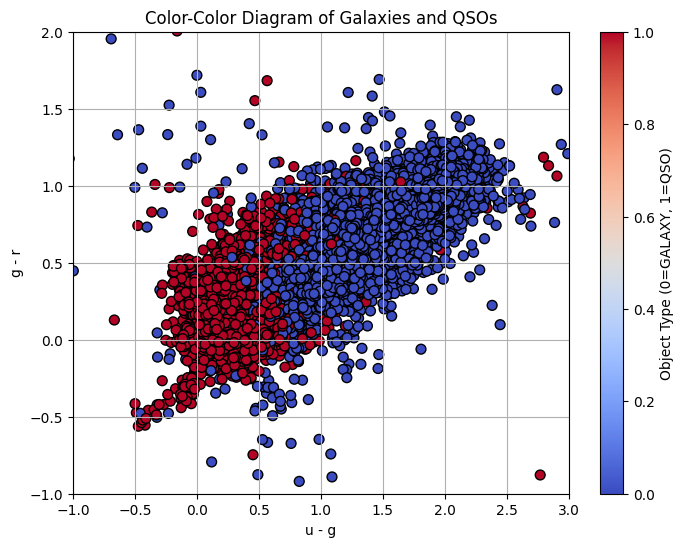

In [35]:
# Plotting the color-color diagram
plt.figure(figsize=(8, 6))
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')

plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('Color-Color Diagram of Galaxies and QSOs')
plt.grid(True)
plt.xlim(-1, 3) #we need this to focus on the interest region
plt.ylim(-1, 2)
plt.show()

#this could be a bimodality, but it is not clear, and also thers the possibility that the other color show the bimodality too
# change of approach: make a corner plot

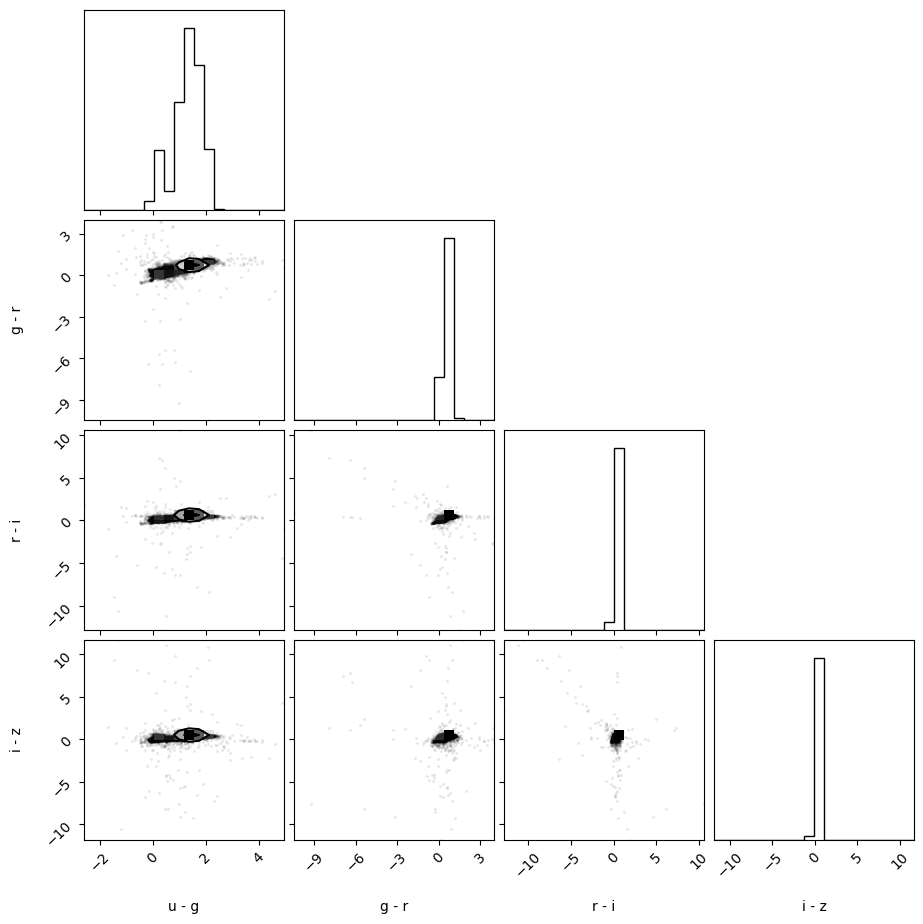

In [36]:
import corner
corner.corner(np.array([u_g, g_r, r_i, i_z]).T, labels=['u - g', 'g - r', 'r - i', 'i - z']);
#without the ";" it print two times the corner plot... 

In [37]:
# only the u-g vs g-r plot shows a bimodality

from sklearn.model_selection import train_test_split as tts

x = np.column_stack((u_g, g_r, r_i, i_z)) #that has shape (N, 4) has sklearn expects
y = QuasGal

x_train, x_test, y_train, y_test = tts(x, y, test_size=0.5, random_state=42)

# **GAUSSIAN NAIVE BAYES**

/tmp/ipykernel_22899/141607492.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f}) with {} feature'.format(np.trapz(tpr, fpr), i+1))
/tmp/ipykernel_22899/141607492.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f}) with {} feature'.format(np.trapz(tpr, fpr), i+1))
/tmp/ipykernel_22899/141607492.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f}) with {} feature'.format(np.trapz(tpr, fpr), i+1))
/tmp/ipykernel_22899/141607492.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integra

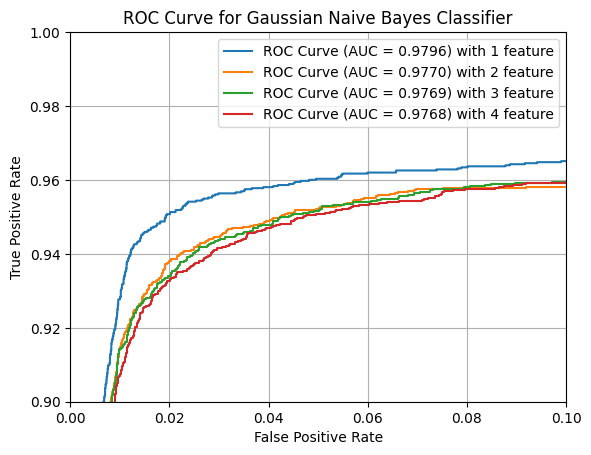

In [38]:
# Evaluation of the model with a ROC curve

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

for i in range(4):  # Test with 1 to 4 features
    X_train_i = x_train[:, :i+1]
    X_test_i = x_test[:, :i+1]
    gnb_i = GaussianNB()
    gnb_i.fit(X_train_i, y_train)
    y_pred = gnb_i.predict_proba(X_test_i)[:, 1] #Predict proba gives a value between 1 and 0 , in a matrix, with [:,1] we take the second column, which is the probability of being a QSO
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f}) with {} feature'.format(np.trapz(tpr, fpr), i+1))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian Naive Bayes Classifier')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

In [39]:
# Plotting the decision boundary  ----------------- this part is usefull to draw the region

xx, yy = np.meshgrid(np.linspace(-1, 3, 300),
                     np.linspace(-1, 2, 300))

# Build input grid using only u-g and g-r
grid_input = np.column_stack([
    xx.ravel(),  # u-g
    yy.ravel()   # g-r
])
#-------------------------------------------------------

x_train_2D = x_train[:, :2]
x_test_2D = x_test[:, :2]

/tmp/ipykernel_22899/2929069181.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


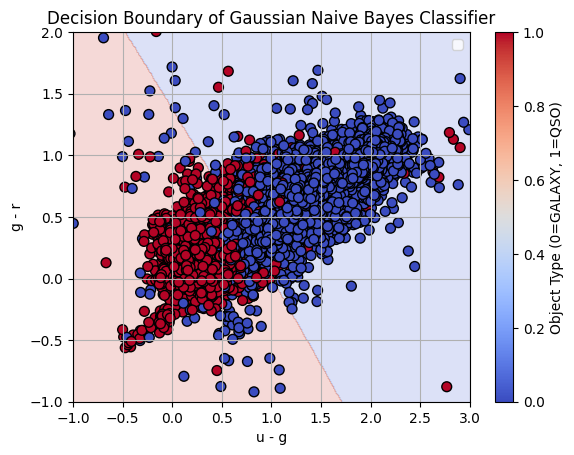

In [40]:
gnb = GaussianNB()

gnb.fit(x_train_2D, y_train) #plot the best with for features

Z = gnb.predict(grid_input).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')

plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')

plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('Decision Boundary of Gaussian Naive Bayes Classifier')
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()

# **LDA & QDA**

/tmp/ipykernel_22899/283109489.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_lda, tpr_lda, label='LDA ROC Curve (AUC = {:.6f})'.format(np.trapz(tpr_lda, fpr_lda)))
/tmp/ipykernel_22899/283109489.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_lda, tpr_lda, label='LDA ROC Curve (AUC = {:.6f})'.format(np.trapz(tpr_lda, fpr_lda)))
/tmp/ipykernel_22899/283109489.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_lda, tpr_lda, label='LDA ROC Curve (AUC = {:.6f})'.format(np.trapz(tpr_lda, fpr_lda)))
/tmp/ipykernel_22899/283109489.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`

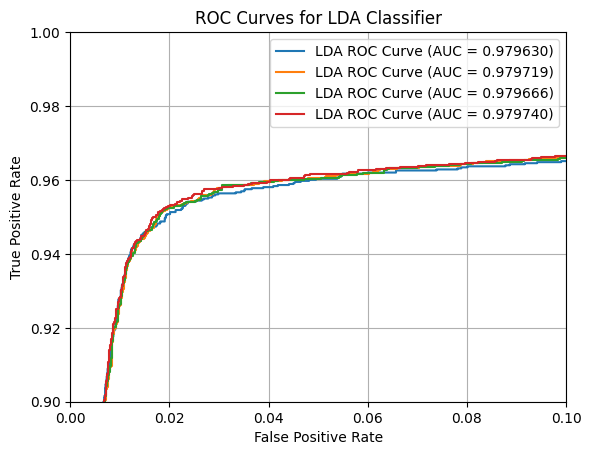

/tmp/ipykernel_22899/283109489.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_qda, tpr_qda, label='QDA ROC Curve (AUC = {:.4f}), with {} features'.format(np.trapz(tpr_qda, fpr_qda), i+1))
/tmp/ipykernel_22899/283109489.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_qda, tpr_qda, label='QDA ROC Curve (AUC = {:.4f}), with {} features'.format(np.trapz(tpr_qda, fpr_qda), i+1))
/tmp/ipykernel_22899/283109489.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_qda, tpr_qda, label='QDA ROC Curve (AUC = {:.4f}), with {} features'.format(np.trapz(tpr_qda, fpr_qda), i+1))
/tmp/ipykernel_22899/283109489.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instea

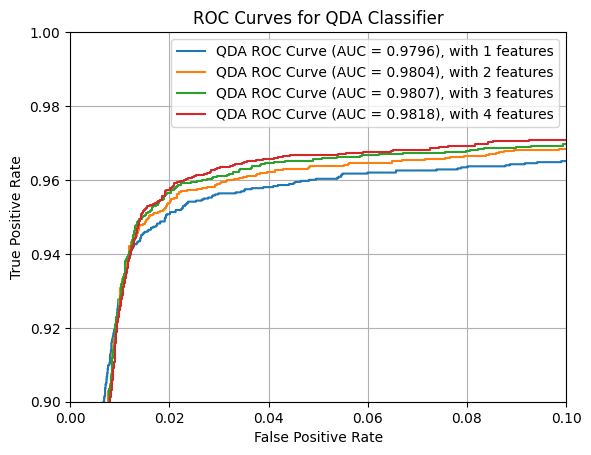

In [41]:
# analyzing the results of LDA and QDA with ROC curves

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

lda = LDA()
qda = QDA()

for i in range(4):  # Test with 1 to 4 features
    X_train_i = x_train[:, :i+1]
    X_test_i = x_test[:, :i+1]
    lda.fit(X_train_i, y_train)

    y_pred_lda_proba = lda.predict_proba(X_test_i)[:, 1] 
    fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test, y_pred_lda_proba)
    plt.plot(fpr_lda, tpr_lda, label='LDA ROC Curve (AUC = {:.6f})'.format(np.trapz(tpr_lda, fpr_lda)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for LDA Classifier')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

for i in range(4):  # Test with 1 to 4 features
    X_train_i = x_train[:, :i+1]
    X_test_i = x_test[:, :i+1]
    qda.fit(X_train_i, y_train)

    y_pred_qda_proba = qda.predict_proba(X_test_i)[:, 1]
    fpr_qda, tpr_qda, thresholds_qda = roc_curve(y_test, y_pred_qda_proba)
    plt.plot(fpr_qda, tpr_qda, label='QDA ROC Curve (AUC = {:.4f}), with {} features'.format(np.trapz(tpr_qda, fpr_qda), i+1))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for QDA Classifier')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

/tmp/ipykernel_22899/3057443543.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


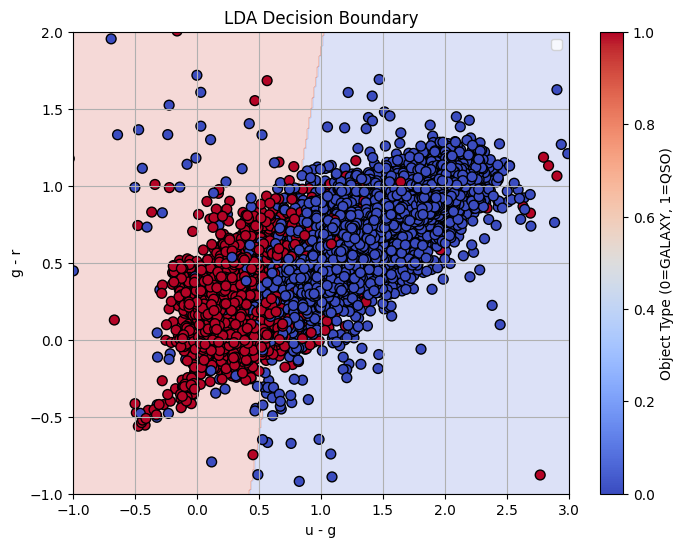

/tmp/ipykernel_22899/3057443543.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


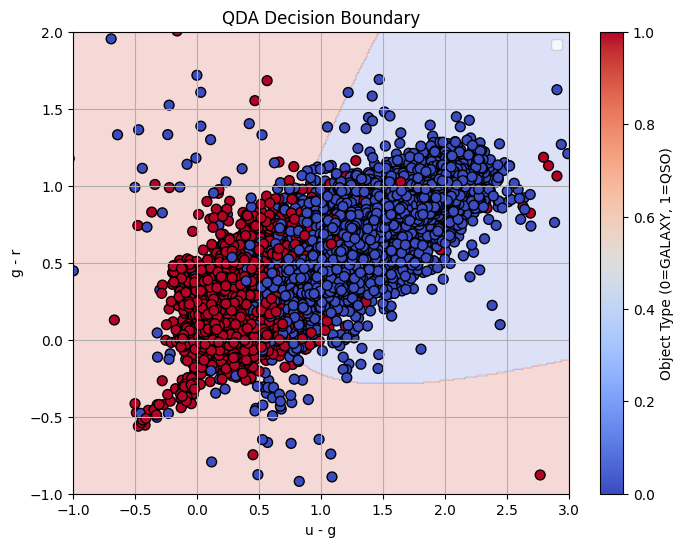

In [43]:
qda.fit(x_train_2D, y_train)
lda.fit(x_train_2D, y_train)


# Plotting the decision boundary for LDA
Z_lda = lda.predict(grid_input).reshape(xx.shape)
# Plotting the decision boundary for QDA
Z_qda = qda.predict(grid_input).reshape(xx.shape)


plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_lda, alpha=0.2, cmap='coolwarm')
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('LDA Decision Boundary')              
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_qda, alpha=0.2, cmap='coolwarm')
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('QDA Decision Boundary')
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()

# **GMM BAYES**

/tmp/ipykernel_22899/1636336078.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_gmm, tpr_gmm, label='GMM ROC Curve (AUC = {:.4f}), with {} features'.format(np.trapz(tpr_gmm, fpr_gmm), i+1))
/tmp/ipykernel_22899/1636336078.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_gmm, tpr_gmm, label='GMM ROC Curve (AUC = {:.4f}), with {} features'.format(np.trapz(tpr_gmm, fpr_gmm), i+1))
/tmp/ipykernel_22899/1636336078.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr_gmm, tpr_gmm, label='GMM ROC Curve (AUC = {:.4f}), with {} features'.format(np.trapz(tpr_gmm, fpr_gmm), i+1))
/tmp/ipykernel_22899/1636336078.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` in

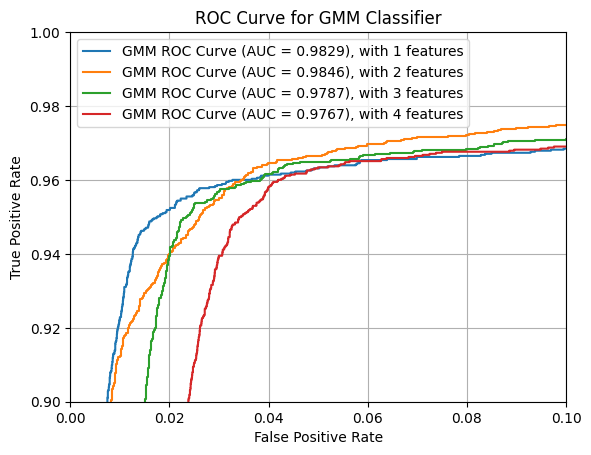

In [ ]:
from astroML.classification import GMMBayes

for i in range(4):  # Test with 1 to 4 features
    X_train_i = x_train[:, :i+1]
    X_test_i = x_test[:, :i+1]
    gmm = GMMBayes(n_components=2)
    gmm.fit(X_train_i, y_train)

    y_pred_gmm_proba = gmm.predict_proba(X_test_i)[:, 1]
    fpr_gmm, tpr_gmm, thresholds_gmm = roc_curve(y_test, y_pred_gmm_proba)
    plt.plot(fpr_gmm, tpr_gmm, label='GMM ROC Curve (AUC = {:.4f}), with {} features'.format(np.trapz(tpr_gmm, fpr_gmm), i+1))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GMM Classifier')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

/tmp/ipykernel_22899/1196565197.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


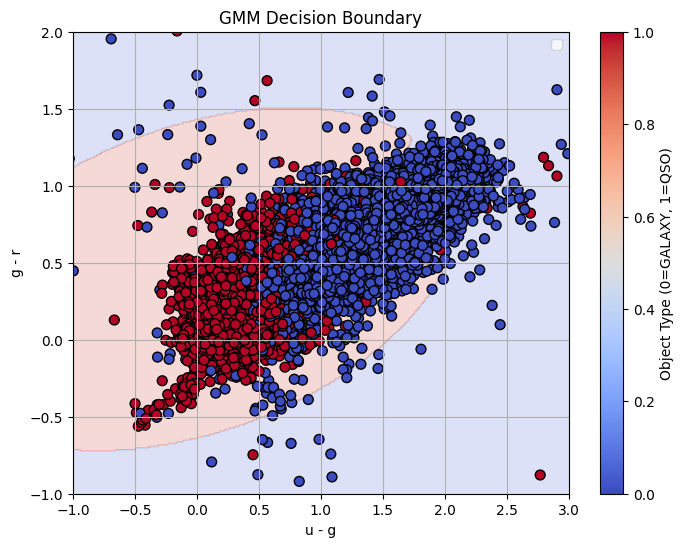

In [44]:

gmm.fit(x_train_2D, y_train)

Z_gmm = gmm.predict(grid_input).reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_gmm, alpha=0.2, cmap='coolwarm')
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('GMM Decision Boundary')
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()

# **K Neighbors**

/tmp/ipykernel_22899/4047269570.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_knn, fpr_knn)
/tmp/ipykernel_22899/4047269570.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_knn, fpr_knn)
/tmp/ipykernel_22899/4047269570.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_knn, fpr_knn)
/tmp/ipykernel_22899/4047269570.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_knn, fpr_knn)
/tmp/ipykernel_22899/4047269570.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.in

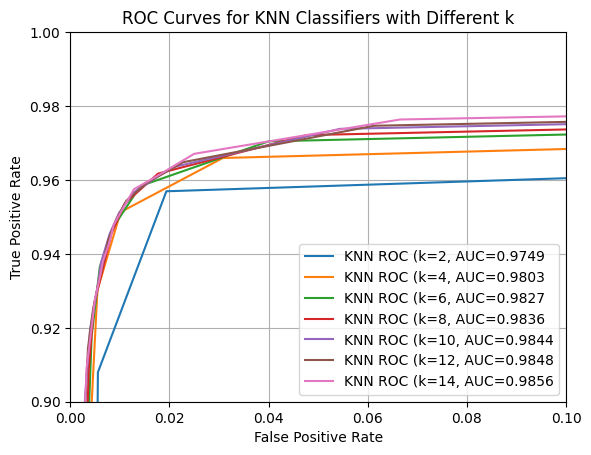

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

for n in range(2, 15, 2):
    KNC = KNeighborsClassifier(n_neighbors=n)
    KNC.fit(x_train, y_train)
    y_pred_knn_proba = KNC.predict_proba(x_test)[:,1]
    fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn_proba)
    auc = np.trapz(tpr_knn, fpr_knn)
    plt.plot(fpr_knn, tpr_knn, label=f'KNN ROC (k={n}, AUC={auc:.4f}')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN Classifiers with Different k')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()


/tmp/ipykernel_22899/3273950312.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


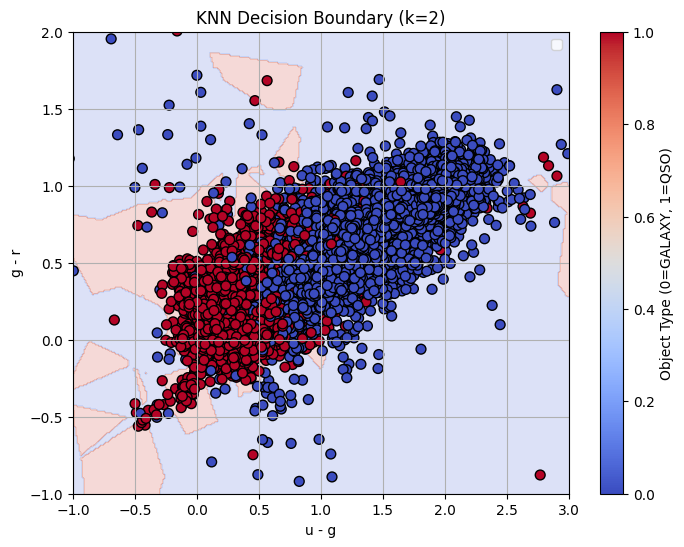

/tmp/ipykernel_22899/3273950312.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


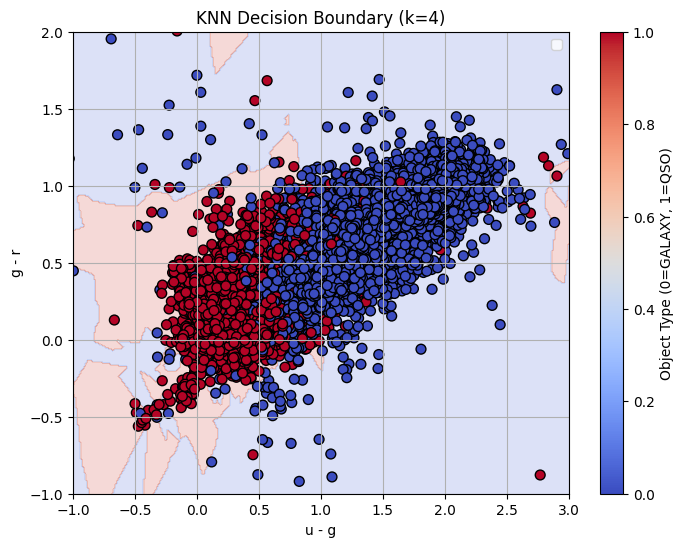

/tmp/ipykernel_22899/3273950312.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


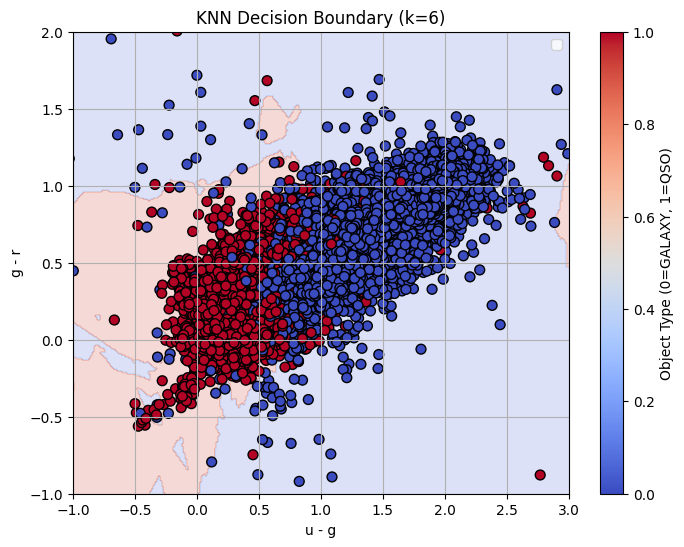

/tmp/ipykernel_22899/3273950312.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


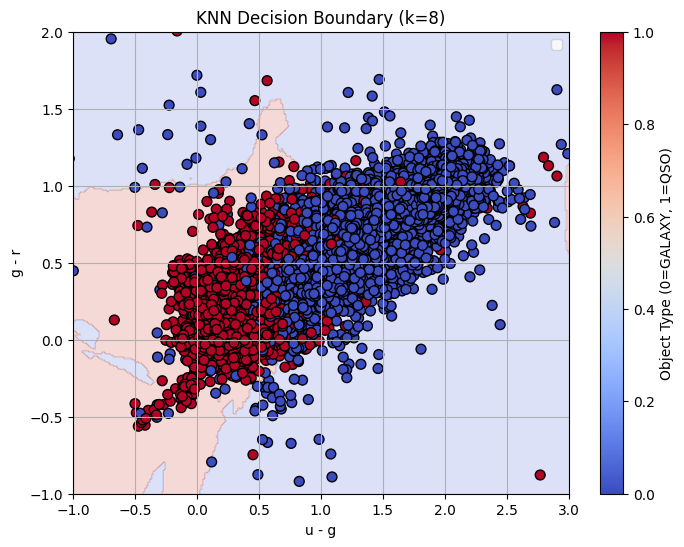

/tmp/ipykernel_22899/3273950312.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


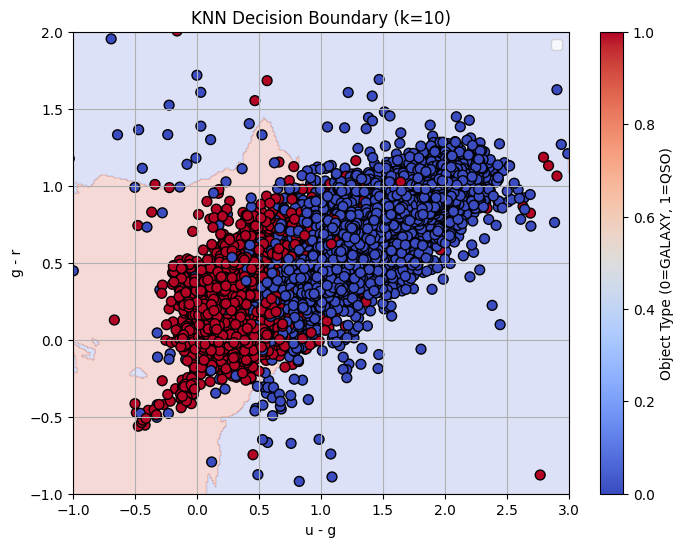

/tmp/ipykernel_22899/3273950312.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


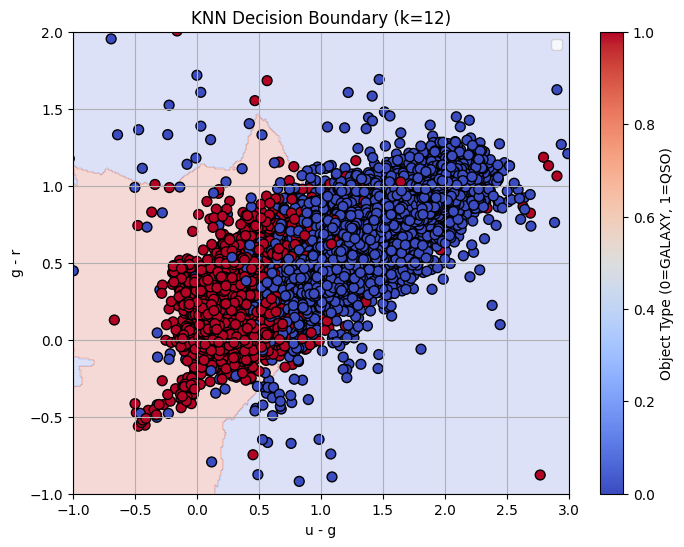

/tmp/ipykernel_22899/3273950312.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


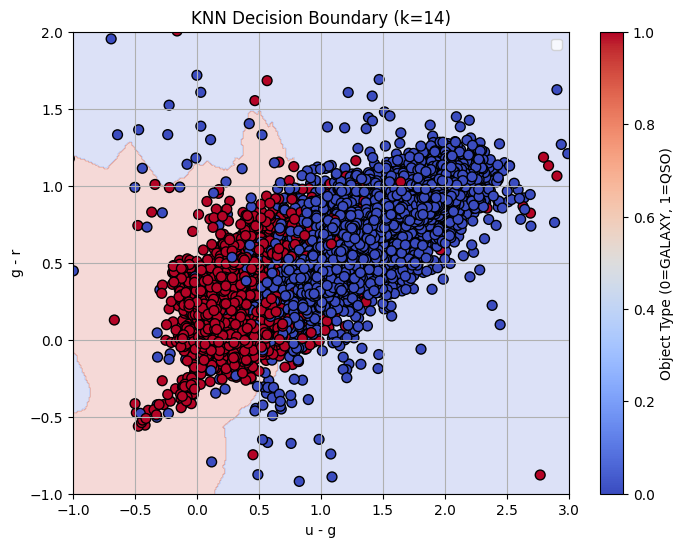

In [45]:
for n in range(2, 15, 2):
    KNC = KNeighborsClassifier(n_neighbors=n)
    KNC.fit(x_train_2D, y_train)

    Z_knn = KNC.predict(grid_input).reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z_knn, alpha=0.2, cmap='coolwarm')
    plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
    plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')
    plt.xlabel('u - g')
    plt.ylabel('g - r')
    plt.title(f'KNN Decision Boundary (k={n})')
    plt.grid(True)
    plt.legend()
    plt.xlim(-1, 3)
    plt.ylim(-1, 2)
    plt.show()
